##### Copyright 2025 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Multimodal RAG using llamaindex and Gemini

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/example/Multimodal_RAG_for_youtube_videos.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/>

## Overview

This notebook demonstrates how to build a multimodal retrieval system that can process and retrieve relevant information from both text and images of a youtube video using LlamaIndex and Gemini.

Having a visual context is important when some relevant text or information is on the slide/chart but not spoken.

In [1]:
%pip install -U -q "google-genai>=1.0.0"

## Installing the necessary libraries

In [2]:
#For extracting transcripts from YouTube videos
%pip install youtube-transcript-api
#For editing and processing videos
%pip install moviepy
# For downloading YouTube videos
%pip install yt_dlp

#LlamaIndex library
%pip install llama_index

#For using OpenAI's CLIP model for image embeddings
%pip install git+https://github.com/openai/CLIP.git
%pip install llama-index-embeddings-clip

#Transformers and PyTorch
%pip install llama-index transformers torch

#For using Hugging Face models to generate text embeddings
%pip install llama-index-embeddings-huggingface

#For using Qdrant as a local vector database
%pip install qdrant-client
%pip install llama_index.vector_stores.qdrant


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.2/129.2 kB 10.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1l5w_1_5
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-1l5w_1_5
  Resolved https

## Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](../quickstarts/Authentication.ipynb) quickstart for an example.

In [4]:
from google.colab import userdata
from google import genai

GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
gemini_client = genai.Client(api_key=GOOGLE_API_KEY)

In [5]:
import os
import google.generativeai as genai
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
genai.configure(api_key=os.environ["GOOGLE_API_KEY"])

## Step-by-step workflow for multimodal RAG


## Extract transcript with times stamps from the youtube video

It takes a YouTube video URL as input, extracts the transcript using the youtube-transcript-api, and includes readable timestamps in the format of [HH:MM:SS]

Then, you store the transcript as a text file in the output folder.

In [6]:
from youtube_transcript_api import YouTubeTranscriptApi
from datetime import timedelta

def get_youtube_transcript(video_url):
    video_id = video_url.split('v=')[1]
    transcript = YouTubeTranscriptApi.get_transcript(video_id)

    formatted_transcript = "\n".join([
        f"[{str(timedelta(seconds=int(item['start'])))}] {item['text']}"
        for item in transcript
    ])

    return formatted_transcript

In [7]:
video_url = "https://www.youtube.com/watch?v=wjZofJX0v4M"
transcript = get_youtube_transcript(video_url)

In [8]:
import os

main_output_folder = "./all_data/"
if not os.path.exists(main_output_folder):
    os.makedirs(main_output_folder)
with open(main_output_folder+"transcript.txt", "w", encoding="utf-8") as file:
    file.write(transcript)

print("Transcript saved to transcript.txt")


Transcript saved to transcript.txt


## Downloading YouTube video

This downloads a YouTube video using the yt_dlp library and saves it as 'downloaded_video.mp4'.

This step is useful when you want to perform tasks like frame extraction, audio processing, or visual analysis on the video locally.


In [9]:
from yt_dlp import YoutubeDL

def download_youtube_video(video_url, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    video_path = os.path.join(output_folder, "downloaded_video.mp4")
    ydl_opts = {
        'format': 'best',
        'outtmpl': video_path,
    }

    with YoutubeDL(ydl_opts) as ydl:
        ydl.download([video_url])

    print("Downloaded video : ", video_path)
    return video_path

In [10]:
output_folder = "downloaded_video"
download_youtube_video(video_url, output_folder)

[youtube] Extracting URL: https://www.youtube.com/watch?v=wjZofJX0v4M
[youtube] wjZofJX0v4M: Downloading webpage
[youtube] wjZofJX0v4M: Downloading tv client config
[youtube] wjZofJX0v4M: Downloading player 73381ccc-main
[youtube] wjZofJX0v4M: Downloading tv player API JSON
[youtube] wjZofJX0v4M: Downloading ios player API JSON
[youtube] wjZofJX0v4M: Downloading m3u8 information
[info] wjZofJX0v4M: Downloading 1 format(s): 18
[download] Destination: downloaded_video/downloaded_video.mp4
[download] 100% of   60.67MiB in 00:00:01 at 43.77MiB/s  
Downloaded video :  downloaded_video/downloaded_video.mp4


'downloaded_video/downloaded_video.mp4'

## Extracting Frames from a Video

This extracts frames from a given video file at regular time intervals(here 1 frame per 5 seconds ) using `moviepy`. The frames are saved as .jpg images in the specified output folder.

This prepares the dataset of images from which the images will be retrieved during RAG

In [11]:
from moviepy.editor import VideoFileClip
import os


def extract_frames_from_video(video_path, output_folder, interval_seconds):
    # Create output directory if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Load video
    clip = VideoFileClip(video_path)

    # Loop through the video duration
    for t in range(0, int(clip.duration), interval_seconds):
        frame_path = os.path.join(output_folder, f"frame_{t:04d}.jpg")
        clip.save_frame(frame_path, t)
        print(f"Saved {frame_path}")

    print("Extraction complete!")

  if event.key is 'enter':



In [12]:
video_path = "/content/downloaded_video/downloaded_video.mp4"
extract_frames_from_video(video_path, main_output_folder, interval_seconds=5)

Saved ./all_data/frame_0000.jpg
Saved ./all_data/frame_0005.jpg
Saved ./all_data/frame_0010.jpg
Saved ./all_data/frame_0015.jpg
Saved ./all_data/frame_0020.jpg
Saved ./all_data/frame_0025.jpg
Saved ./all_data/frame_0030.jpg
Saved ./all_data/frame_0035.jpg
Saved ./all_data/frame_0040.jpg
Saved ./all_data/frame_0045.jpg
Saved ./all_data/frame_0050.jpg
Saved ./all_data/frame_0055.jpg
Saved ./all_data/frame_0060.jpg
Saved ./all_data/frame_0065.jpg
Saved ./all_data/frame_0070.jpg
Saved ./all_data/frame_0075.jpg
Saved ./all_data/frame_0080.jpg
Saved ./all_data/frame_0085.jpg
Saved ./all_data/frame_0090.jpg
Saved ./all_data/frame_0095.jpg
Saved ./all_data/frame_0100.jpg
Saved ./all_data/frame_0105.jpg
Saved ./all_data/frame_0110.jpg
Saved ./all_data/frame_0115.jpg
Saved ./all_data/frame_0120.jpg
Saved ./all_data/frame_0125.jpg
Saved ./all_data/frame_0130.jpg
Saved ./all_data/frame_0135.jpg
Saved ./all_data/frame_0140.jpg
Saved ./all_data/frame_0145.jpg
Saved ./all_data/frame_0150.jpg
Saved ./

## Setting up the text embedding model

This configures a Hugging Face embedding model (BAAI/bge-small-en-v1.5) for text embeddings using llama_index.

Embedding models convert text into numerical vectors for efficient similarity search and retrieval.

#### NOTE : This below cell is optional since you are using a public model but it is always a better choice to authenticate.

To run the following cell, your hugging face access token must be stored in a Colab Secret named HF_TOKEN. If you don't already have the access token refer this [link](https://huggingface.co/docs/hub/en/security-tokens).

In [13]:
import os
from huggingface_hub import login

# Set the Hugging Face token in the environment variable
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

# Log in using the token
login(token=os.getenv('HF_TOKEN'))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)

## Setting Up a MultiModal Vector Store

This initializes a MultiModal Vector Store Index using `Qdrant`, a vector database for storing and retrieving embeddings of both text and images. Even though they are two embeddings both are stored in the same vector space to enable efficient retrieval.

Steps followed -
- Create a local Qdrant database (local_db)

- Define separate stores for text and image embeddings

- Load extracted images and transcript from the `./all_data/ ` folder

- Build a MultiModal index to enable efficient retrieval of text and images

In [15]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import SimpleDirectoryReader, StorageContext

import qdrant_client
from llama_index.core import SimpleDirectoryReader

# Create a local Qdrant vector store
client = qdrant_client.QdrantClient(path="local_db")

# Below is the store for text embeddings
text_store = QdrantVectorStore(client=client, collection_name="text_collection")

# Below is the store for image embeddings
image_store = QdrantVectorStore(client=client, collection_name="image_collection")

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

# this folder contains the extarcted images and transcriot
documents = SimpleDirectoryReader("./all_data/").load_data()

# Create the MultiModal index
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 241MiB/s]
  self._client.create_payload_index(



## Creating the multi-modal retriever

This code converts the multi-modal index into a retriever engine, allowing retrieval of the top 5 most similar text and image embeddings based on the query. This enables searching across both text and images efficiently.

The number can be changed as per preference.

In [16]:
retriever_engine = index.as_retriever(
    similarity_top_k=5, image_similarity_top_k=5
)

## Retrieving relevant text and images.

 It takes a query and uses the retriever engine to fetch the most relevant text and images. If the retrieved node is an image, its file path is stored, while for text nodes, the first 200 characters are displayed along with the similarity score.

In [17]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


def retrieve(retriever_engine, query):
    retrieval_results = retriever_engine.retrieve(query)

    retrieved_images = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_images.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_images, retrieved_text

### Function to make the retrieval based on the query

In [18]:
def make_retrieval(query):
    image_paths, text = retrieve(retriever_engine=retriever_engine, query=query)
    image_documents = SimpleDirectoryReader(
        input_dir=output_folder, input_files=image_paths
    ).load_data()
    text_context = "".join(text)
    return image_paths, text_context


### Function to display the top 5 images retrieved

In [19]:
import matplotlib.pyplot as plt
import cv2

def display_images(image_paths):
    images = [cv2.imread(path) for path in image_paths]
    plt.figure(figsize=(10, 7))

    for i, image in enumerate(images):
        plt.subplot(2, 3, i + 1)  # 2 rows, 3 columns
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")

    plt.show()

## Setting up gemini model and uploading images

This uses the `gemini-2.0-flash` model.

You initializes the Gemini model with a specified configuration, including parameters like temperature, top-p, top-k, and token limits to control response generation.

Next, upload images to Gemini, which takes an image path and uploads it. Finally, all five images are uploaded storing their references generating responses.

In [20]:
# Setup Gemini Model
generation_config = {
    "temperature": 1,
    "top_p": 0.95,
    "top_k": 64,
    "max_output_tokens": 8192,
    "response_mime_type": "text/plain",
}

model = genai.GenerativeModel(
    model_name="gemini-2.0-flash",
    generation_config=generation_config,
)

In [21]:
def upload_to_gemini(path, mime_type="image/jpeg"):
    file = genai.upload_file(path, mime_type=mime_type)
    print(f"Uploaded file '{file.display_name}'")
    return file

## Constructing a well-structured prompt

You define the prompt for the model, instructing it to analyze both text and image context to generate a comprehenssive response.

The prompt also instructs the model to return "could not find an answer" if relevant information in not available.

In [22]:
def create_prompt(text_context, query, files):
    prompt = [
        "You are an expert LLM model with the ability to process both text and images. Using the provided information:",
        "- Refer to the context provided in the text and the visual details in the images to answer the query comprehensively.",
        "- Be precise and detailed in your response, drawing insights from both the text and images.",
        "- If an explanation requires referencing images, do so explicitly.",
        "",
        f"Text Context:\n{text_context}\n",
        "Images: Provided in image_context\n",
        f"Query:\n{query}\n",
        "If you cannot find an answer, reply with 'could not find answer'. Avoid giving gibberish responses.",
        *files,  # Include uploaded images
    ]
    return prompt


### Function to process the query and generate response

In [23]:
def process_query_and_generate_response(query_str):
    image_paths, text_context = make_retrieval(query_str)

    print("\n\n")
    print("Retrieved Text Context (First 500 characters):\n")
    print(text_context[:500])
    print("\n\n")

    print("Displaying Retrieved Images:\n")
    display_images(image_paths)
    print("\n\n")

    print("Uploading Images to Gemini:\n")
    files = [upload_to_gemini(path) for path in image_paths]
    print("\n\n")

    prompt = create_prompt(text_context, query_str, files)
    response = model.generate_content(prompt)
    return response


 ### Example Query 1

In [30]:
query1 = "What is the blue wild pi creature mentioned in the video ?"
# refer to 0.58s

**Node ID:** eb5dadca-55e3-4a9c-806d-85e89c491911<br>**Similarity:** 0.6169211473903135<br>**Text:** [0:02:22] The story just doesn't actually really make that much sense.
[0:02:26] But if I swap it out for API calls to GPT-3 instead, which is the same basic model,
[0:02:31] just much bigger, sudd...<br>

**Node ID:** d1f8ee09-9301-4b4e-a7a2-d0c7454fa75a<br>**Similarity:** 0.5860756851431598<br>**Text:** [0:00:00] The initials GPT stand for Generative Pretrained Transformer.
[0:00:05] So that first word is straightforward enough, these are bots that generate new text.
[0:00:09] Pretrained refers to...<br>

**Node ID:** b820c05a-76b8-4e44-845a-b8c043a3293c<br>**Similarity:** 0.5522827344975828<br>**Text:** [0:07:03] After that, I want to talk more about these multi-layer perceptron blocks,
[0:07:06] how training works, and a number of other details that will have been skipped up to
[0:07:11] that poi...<br>

**Node ID:** c1d834b9-b53d-4d40-8d4b-f991bbc8f639<br>**Similarity:** 0.5520234335183063<br>**Text:** [0:26:32] For that, come join me in the next chapter.
[0:26:36] As I'm publishing this, a draft of that next chapter
[0:26:38] is available for review by Patreon supporters.
[0:26:41] A final versi...<br>

**Node ID:** 01d23610-eab1-4f52-b3d3-f60a44431988<br>**Similarity:** 0.5482156202729099<br>**Text:** [0:04:43] And while this block is a little bit harder to interpret,
[0:04:45] later on we'll talk about how the step is a little bit like asking a long list
[0:04:49] of questions about each vector...<br>




Retrieved Text Context (First 500 characters):

[0:02:22] The story just doesn't actually really make that much sense.
[0:02:26] But if I swap it out for API calls to GPT-3 instead, which is the same basic model,
[0:02:31] just much bigger, suddenly almost magically we do get a sensible story,
[0:02:35] one that even seems to infer that a pi creature would live in a land of math and
[0:02:40] computation.
[0:02:41] This process here of repeated prediction and sampling is essentially
[0:02:44] what's happening when you interact with ChatGPT,
[



Displaying Retrieved Images:



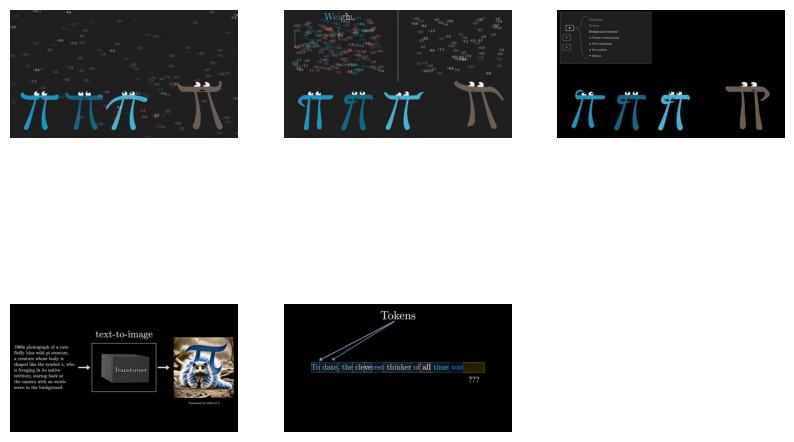




Uploading Images to Gemini:

Uploaded file 'frame_0720.jpg'
Uploaded file 'frame_0725.jpg'
Uploaded file 'frame_0415.jpg'
Uploaded file 'frame_0060.jpg'
Uploaded file 'frame_0205.jpg'





In [31]:
response = process_query_and_generate_response(query1)

In this below response you can clearly realize that it has extracted data from both text and images.
Not everything in the response generated is spoken, some things are written on the one of the images extracted.

This shows the importance of requiring visual context to generate accurate responses.

In [32]:
import textwrap
print(textwrap.fill(response.text, width=100))

Based on the text and images provided, the "blue wild pi creature" is a concept used to test the
ability of language models like GPT-2 and GPT-3 to generate coherent stories. The image shows what
the model creates. The model created a cute, fluffy, blue, wild pi creature, whose body is shaped
like the symbol π. It is foraging in its native territory and staring back at the camera with an
exotic scene in the background. The success of GPT-3 in creating a sensible story that includes this
creature is highlighted as an example of the advancements in AI.


### Example query 2

In [27]:
query2 = "What is the reference shown about quill? Elaborate on it"
# refer to 19.07 of the video

**Node ID:** eb5dadca-55e3-4a9c-806d-85e89c491911<br>**Similarity:** 0.6029041969227328<br>**Text:** [0:02:22] The story just doesn't actually really make that much sense.
[0:02:26] But if I swap it out for API calls to GPT-3 instead, which is the same basic model,
[0:02:31] just much bigger, sudd...<br>

**Node ID:** 3167a7b6-ffd9-4dc3-b498-03befe18017b<br>**Similarity:** 0.5864687559184871<br>**Text:** [0:14:21] The big idea here is that as a model tweaks and tunes its weights to determine
[0:14:25] how exactly words get embedded as vectors during training,
[0:14:28] it tends to settle on a set o...<br>

**Node ID:** 01d23610-eab1-4f52-b3d3-f60a44431988<br>**Similarity:** 0.5675713539592879<br>**Text:** [0:04:43] And while this block is a little bit harder to interpret,
[0:04:45] later on we'll talk about how the step is a little bit like asking a long list
[0:04:49] of questions about each vector...<br>

**Node ID:** 1773130b-4fcf-449a-b3a1-38c798ccd609<br>**Similarity:** 0.5652990167778424<br>**Text:** [0:23:42] But it's softer than just picking the max in the sense that when other values
[0:23:46] are similarly large, they also get meaningful weight in the distribution,
[0:23:50] and everything ...<br>

**Node ID:** d1f8ee09-9301-4b4e-a7a2-d0c7454fa75a<br>**Similarity:** 0.5644249248323464<br>**Text:** [0:00:00] The initials GPT stand for Generative Pretrained Transformer.
[0:00:05] So that first word is straightforward enough, these are bots that generate new text.
[0:00:09] Pretrained refers to...<br>




Retrieved Text Context (First 500 characters):

[0:02:22] The story just doesn't actually really make that much sense.
[0:02:26] But if I swap it out for API calls to GPT-3 instead, which is the same basic model,
[0:02:31] just much bigger, suddenly almost magically we do get a sensible story,
[0:02:35] one that even seems to infer that a pi creature would live in a land of math and
[0:02:40] computation.
[0:02:41] This process here of repeated prediction and sampling is essentially
[0:02:44] what's happening when you interact with ChatGPT,
[



Displaying Retrieved Images:



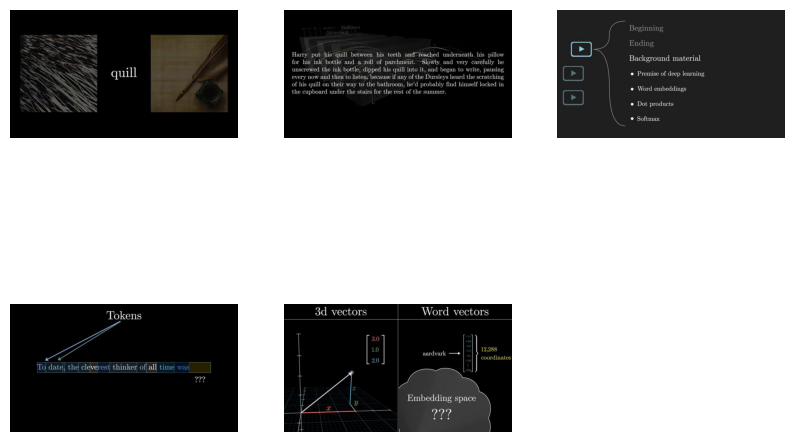




Uploading Images to Gemini:

Uploaded file 'frame_1150.jpg'
Uploaded file 'frame_1210.jpg'
Uploaded file 'frame_0410.jpg'
Uploaded file 'frame_0205.jpg'
Uploaded file 'frame_0835.jpg'





In [28]:
response = process_query_and_generate_response(query2)

The word 'quill' is never spoken by the speaker but the model is able to extract information becasue of the images retrieved.

In [29]:
print(textwrap.fill(response.text, width=100))

Based on the images provided, the reference to "quill" appears in the context of a text excerpt,
specifically from Harry Potter. In the [second image] it states, "Harry put his quill between his
teeth and reached underneath his pillow for his ink bottle and a roll of parchment. Slowly and very
carefully he unscrewed the ink bottle, dipped his quill into it, and began to write, pausing every
now and then to listen, because if any of the Dursleys heard the scratching of his quill on their
way to the bathroom, he'd probably find himself locked in the cupboard under the stairs for the rest
of the summer.". The first image also shows an image of quill and ink.


## Next Steps
### Useful documentation references:
Want to get better at prompting? Check out the [prompt guide](https://ai.google.dev/gemini-api/docs/prompting-strategies
) for tips and strategies.

### Try it yourself
Now that you’ve built a multimodal RAG system, try using one of your own YouTube videos! Test it with different queries and see how combining visual and text information improves the results.

### Continue your discovery of the Gemini API
Next step you would want to take towards learning something unique could be context caching using gemini. Dive into the [context caching guide](https://ai.google.dev/gemini-api/docs/caching?lang=python) to gain insights on it!
